In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp
import data
kn.set_mpl_style()

In [2]:
def savefig(fig, basename, **kwargs):
    fig.savefig("../report/{}.pdf".format(basename), **kwargs)

# Data

In [3]:
df = data.load_hyades_dataset()
b0 = np.array([17.15474298, 41.28962638, 13.69105771])
fit_dict = {
    "cl": kn.load_stanfit("pickles/hyades_0_10.pickle"),
    "tails": kn.load_stanfit("pickles/hyades_10_m_fixed_v0.pickle")
}
azfit_dict = {
    k: kn.add_transformed_posterior(az.from_pystan(v)) for k, v in fit_dict.items()
}

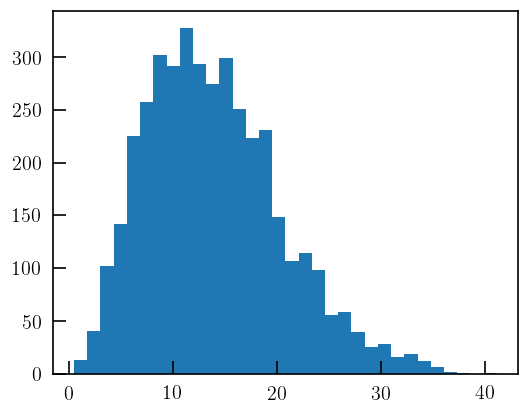

In [16]:
omega_vec = np.vstack([
    azfit_dict['cl'].posterior[l].values.reshape((-1)) for l in ['omegax','omegay','omegaz']])
plt.hist(np.linalg.norm(omega_vec,axis=0), bins=32);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f12c4409910>],
      dtype=object)

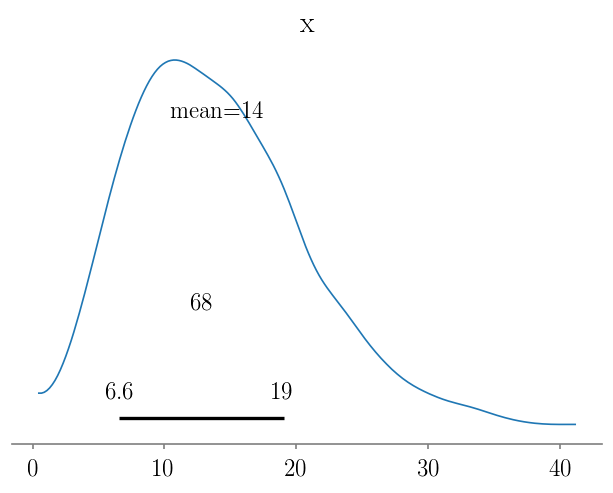

In [18]:
az.plot_posterior(np.linalg.norm(omega_vec,axis=0), credible_interval=0.68)

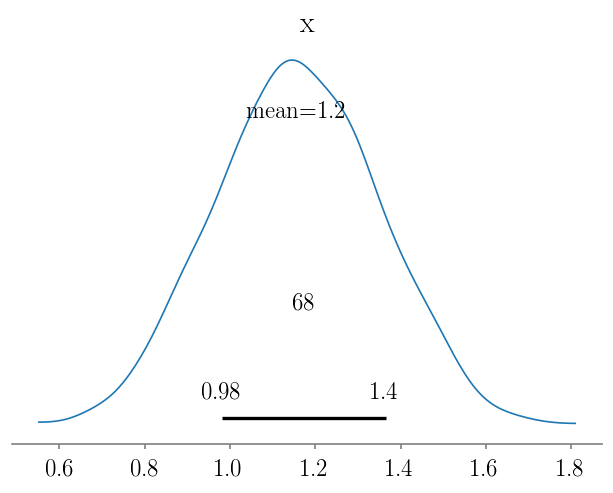

In [59]:
sigv_gal = np.sqrt(azfit_dict['cl'].posterior['Sigma_gal'].values.reshape((-1,3,3))[:,[0,1,2],[0,1,2]])
az.plot_posterior(sigv_gal[:,0]/sigv_gal[:,1], credible_interval=0.68);

In [64]:
az.summary(
    azfit_dict['cl'], var_names=['omegax_gal','omegay_gal','omegaz_gal'],
    credible_interval=0.955)

,mean,sd,hpd_2.25%,hpd_97.75%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
omegax_gal,3.270,5.513,-7.384,14.597,0.114,0.080,2358.0,2358.0,2363.0,3119.0,1.0
omegay_gal,2.236,9.779,-16.464,22.722,0.270,0.191,1308.0,1308.0,1309.0,1817.0,1.0
omegaz_gal,-4.440,8.713,-22.422,12.271,0.216,0.152,1633.0,1633.0,1637.0,2322.0,1.0


In [58]:
np.mean(sigv_gal[:,0])/np.mean(sigv_gal[:,1])

1.1527405935950465

In [43]:
v=azfit_dict['tails'].posterior['T_param_gal'].values.reshape((-1,3,3))

symv = 0.5*(v + np.transpose(v, (0,2,1)))

eig = kn.EigenvalueDecomposition(symv)

([array([398., 685., 792., 608., 413., 258., 198., 208., 200., 240.]),
  array([   0.,   95., 3905.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.]),
  array([   0.,    0.,    0.,    0.,    0.,    0.,   21., 3979.,    0.,
            0.])],
 array([-8.99253416e+01, -7.19379182e+01, -5.39504948e+01, -3.59630713e+01,
        -1.79756479e+01,  1.17754981e-02,  1.79991989e+01,  3.59866223e+01,
         5.39740457e+01,  7.19614692e+01,  8.99488926e+01]),
 <a list of 3 Lists of Patches objects>)

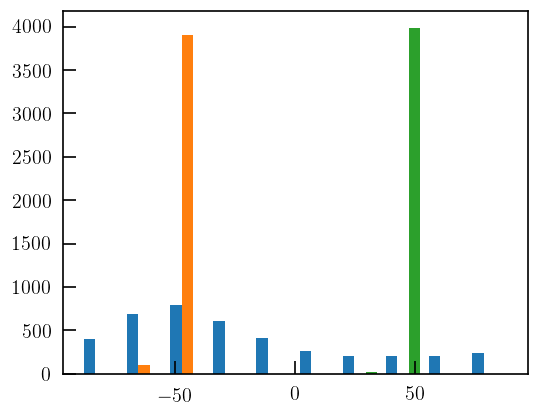

In [49]:
plt.hist(eig.theta)

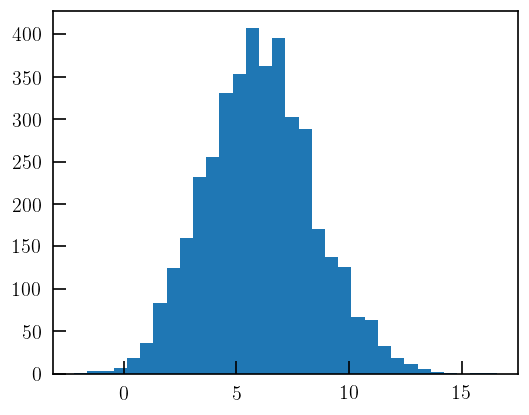

In [53]:
plt.hist(eig.w[:,1:].sum(axis=1),32);

## Mean velocity - comparison to literature

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


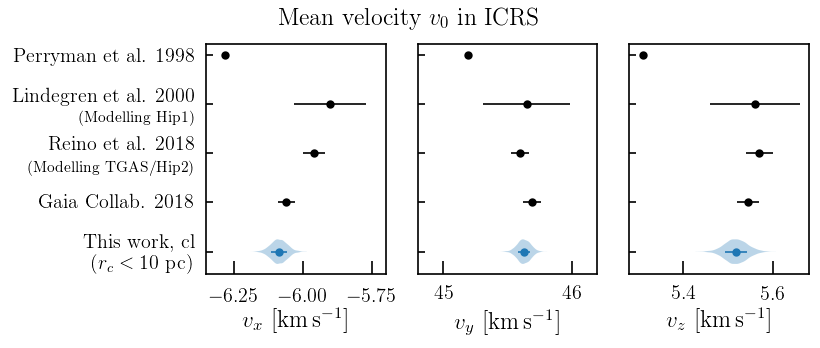

In [5]:
from io import StringIO

prev = pd.read_csv(
    StringIO(
        """
# Compile only the most relevant
label,vx,vx_sig,vy,vy_sig,vz,vz_sig
"Gaia HR",-6.059, 0.031, 45.691,0.069,5.544,0.025
"Reino et al. 2018\nModelling TGAS/Hipparcos-2",-5.96,0.04,45.60,0.07,5.57, 0.03 
"Lindegren et al. 2000\nModelling Hipparcos-1",-5.90,0.13,45.65,0.34,5.56, 0.10 
"Perryman et al. 1998",-6.28,0,45.19,0,5.31,0
"""
    ),
    skipinitialspace=True,
    comment="#",
)

v0df = pd.DataFrame(
    azfit_dict["cl"].posterior["v0"].stack(i=["chain", "draw"]).values.T,
    columns=["vx", "vy", "vz"],
)
# v0df_all = pd.DataFrame(
#     azfit_dict["tails"].posterior["v0"].stack(i=["chain", "draw"]).values.T,
#     columns=["vx", "vy", "vz"],
# )

fig, ax = plt.subplots(1, 3, figsize=(7, 3), sharey=True)
fig.suptitle("Mean velocity $v_0$ in ICRS", y=0.96)
for cax, label in zip(ax, ["vx", "vy", "vz"]):
    # cl
    cax.violinplot(v0df[label], vert=False, positions=[-1,], showextrema=False)
    cax.errorbar(
        np.median(v0df[label]),
        -1,
        xerr=[
            [np.median(v0df[label]) - np.percentile(v0df[label], 16)],
            [np.percentile(v0df[label], 84) - np.median(v0df[label])],
        ],
        marker="o",
        c="C0",
        ms=4,
    )
    # cl+tails
#     cax.violinplot(v0df_all[label], vert=False, positions=[-2,], showextrema=False)
#     cax.errorbar(
#         np.median(v0df_all[label]),
#         -2,
#         xerr=[
#             [np.median(v0df_all[label]) - np.percentile(v0df_all[label], 16)],
#             [np.percentile(v0df_all[label], 84) - np.median(v0df_all[label])],
#         ],
#         marker="o",
#         c="C1",
#         ms=4,
#     )

    cax.errorbar(
        prev[label],
        np.arange(len(prev)),
        xerr=prev["{}_sig".format(label)],
        ls="",
        marker="o",
        c="k",
        ms=4,
    )
ax[0].set_yticks([ -1, 0, 1, 2, 3])
ax[0].set_yticklabels(
    [
#         "This work, tails\n($r_c>10~\mathrm{pc}$)",
        "This work, cl\n($r_c<10~\mathrm{pc}$)",
        "Gaia Collab. 2018",
        "Reino et al. 2018\n{\small (Modelling TGAS/Hip2)}",
        "Lindegren et al. 2000\n{\small (Modelling Hip1)}",
        "Perryman et al. 1998",
    ]
)
ax[0].set_xlim([-6.35, -5.7])
ax[1].set_xlim([44.8, 46.2])
ax[2].set_xlim([5.28, 5.68])
for cax in ax[:]:
    cax.tick_params("y", which="major", length=4)
ax[0].set_xlabel("$v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1].set_xlabel("$v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[2].set_xlabel("$v_z$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
fig.tight_layout(rect=[0, 0, 1, 0.93])
savefig(fig, "mean_velocity_comparison")

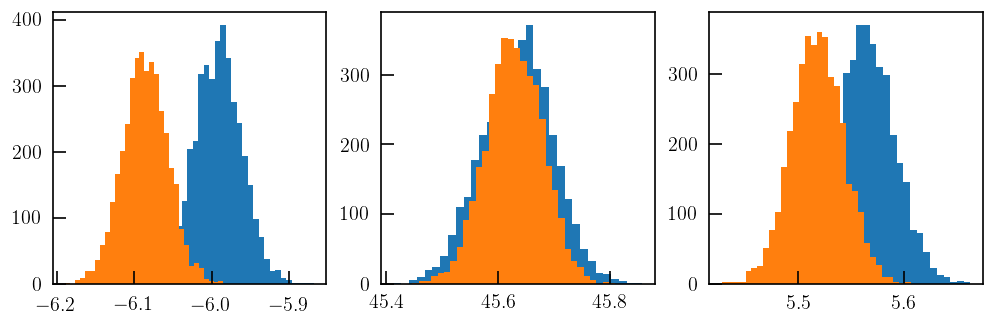

In [124]:
tails_free_v0 = kn.load_stanfit('../scripts/hyades_10_m.pickle')
fig, ax = plt.subplots(1,3,figsize=(10,3))
for i,cax in enumerate(ax):
    cax.hist(tails_free_v0['v0'][:,i], 32);
    cax.hist(fit_dict['cl']['v0'][:,i],32);

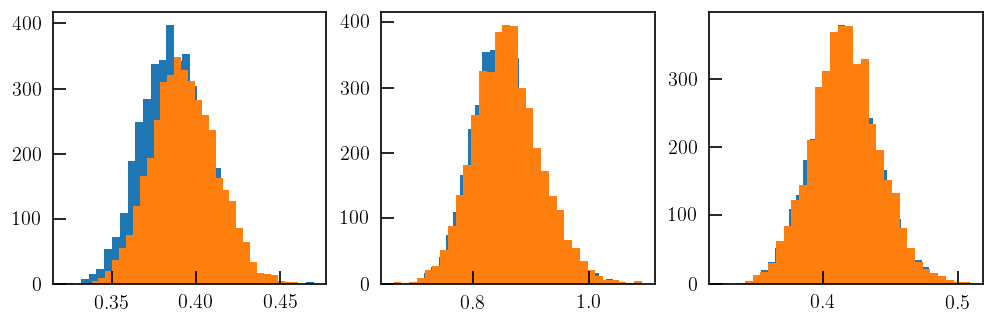

In [126]:
tails_free_v0 = kn.load_stanfit('../scripts/hyades_10_m.pickle')
fig, ax = plt.subplots(1,3,figsize=(10,3))
for i,cax in enumerate(ax):
    cax.hist(tails_free_v0['sigv'][:,i], 32);
    cax.hist(fit_dict['tails']['sigv'][:,i],32);

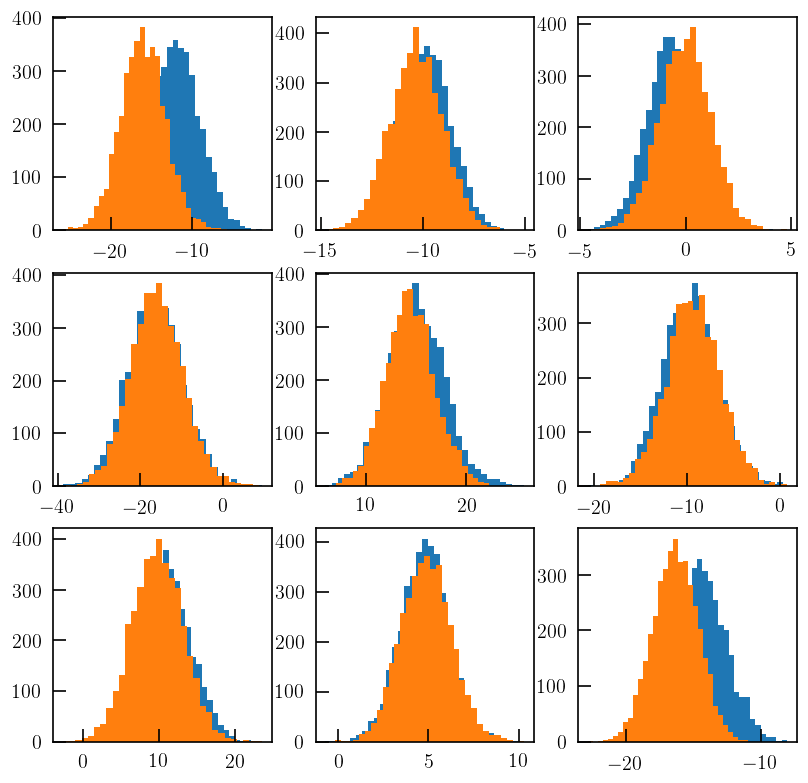

In [128]:
tails_free_v0 = kn.load_stanfit('../scripts/hyades_10_m.pickle')
fig, ax = plt.subplots(3,3,figsize=(8,8))
for i in range(3):
    for j in range(3):
        cax=ax[i,j]
        cax.hist(tails_free_v0['T_param'][:,i,j], 32);
        cax.hist(fit_dict['tails']['T_param'][:,i,j],32);

# Velocity dispersion

In [6]:
sigv_x_gal = np.sqrt(azfit_dict['cl'].posterior['Sigma_gal'][:,:,0,0].values)
sigv_y_gal = np.sqrt(azfit_dict['cl'].posterior['Sigma_gal'][:,:,1,1].values)
sigv_y_gal = np.sqrt(azfit_dict['cl'].posterior['Sigma_gal'][:,:,1,1].values)
print("sigma_x/simga_y = {:8.3f} +- {:8.3f}".format(
    (sigv_x_gal/sigv_y_gal).mean(),(sigv_x_gal/sigv_y_gal).std()))

sigma_x/simga_y =    1.155 +-    0.190


In [12]:
%run utils.ipynb

C0 cl
0 0.4417682776979243 0.06973783129691541
1 0.38323303625508987 0.016565638268814138
2 0.37101020845209975 0.05560458954122933
C1 tails
0 0.8068997579635419 0.04973214944868355
1 0.5149338556665309 0.03473879129449683
2 0.38922974149404516 0.016628917704817572


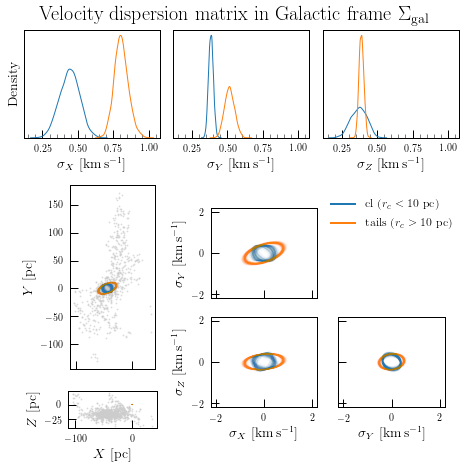

In [19]:
# Figure: posterior velocity disperion in Galactic frame
def cleanyticks(cax):
    cax.set_yticks([])


from matplotlib.lines import Line2D


fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.subplots(
    2, 2, gridspec_kw=dict(top=0.55, left=0.45, right=0.95), sharex=True, sharey=True
)
plt.delaxes(ax[0, 1])

axhist = fig.subplots(
    1,
    3,
    gridspec_kw=dict(bottom=0.7, left=0.05, right=0.98, top=0.93, wspace=0.1),
    sharex=True,
)
for cax, axis in zip(axhist, ["X", "Y", "Z"]):
    cax.set_xlabel(r"$\sigma_{}$ [$\mathrm{{km}}\,\mathrm{{s}}^{{-1}}$]".format(axis))
    cleanyticks(cax)
axhist[0].set_ylabel("Density")
# for cax in axhist: cax.axvline(0.3, c='k', lw=1)

center_gal = np.array([-43.9034441, 0.17206561, -17.02724708])
scale = (
    20  # arbitrary multiplcation factor to make covar ellipse visible with positions
)
axOver = fig.subplots(
    2,
    1,
    gridspec_kw=dict(left=0.08, bottom=0.08, right=0.4, top=0.6, height_ratios=[5, 1]),
    sharex=True,
)
cdf = df.groupby(df["Member_r19"] != "other").get_group(True)
axOver[0].scatter(cdf["gx"], cdf["gy"], s=1, c="0.8", alpha=0.5)
axOver[1].scatter(cdf["gx"], cdf["gz"], s=1, c="0.8", alpha=0.5)
for cax in axOver:
    cax.set_aspect("equal")
axOver[1].set_xlabel("$X$ [pc]")
axOver[1].set_ylabel("$Z$ [pc]")
axOver[0].set_ylabel("$Y$ [pc]")

for (k, azfit), color in zip(azfit_dict.items(), ["C0", "C1", "C0", "C1"]):
    print(color, k)
    cov = azfit.posterior["Sigma_gal"].stack(i=["chain", "draw"]).values

    for i in np.random.randint(0, 4000, size=400):
        # x-y
        plot_cov_ellipse(
            cov[:, :, i], ax=ax[0, 0], n_std=1, edgecolor=color, alpha=0.1, lw=0.1
        )
        plot_cov_ellipse(
            cov[:, :, i],
            ax=axOver[0],
            center=center_gal[[0, 1]],
            n_std=scale,
            edgecolor=color,
            alpha=0.1,
            lw=0.1,
        )
        # x-z
        for cax in (ax[1, 0], axOver[1]):
            plot_cov_ellipse(
                cov[:, :, i],
                xaxis=0,
                yaxis=2,
                ax=cax,
                n_std=1,
                edgecolor=color,
                alpha=0.1,
                lw=0.1,
            )
        # y-z
        plot_cov_ellipse(
            cov[:, :, i],
            xaxis=1,
            yaxis=2,
            ax=ax[1, 1],
            n_std=1,
            edgecolor=color,
            alpha=0.1,
            lw=0.1,
        )

    for ii in range(3):
        #         axhist[ii].set_xlim(0, 1.6)
        axhist[ii].minorticks_on()
        axhist[ii].tick_params(axis="x", which="minor", length=4, width=0.5)
        sns.kdeplot(np.sqrt(cov[ii, ii]), ax=axhist[ii], color=color)
        print(ii, (np.sqrt(cov[ii, ii])).mean(), (np.sqrt(cov[ii, ii])).std())

ax[0, 0].axis([-2.2, 2.2, -2.2, 2.2])
# make all ticklabels positive as there is no minus dispersion?

# add a custom figure legend
custom_lines = [
    Line2D([0], [0], color="C0", lw=2),
    Line2D([0], [0], color="C1", lw=2),
]
fig.legend(
    custom_lines,
    ["cl ($r_c<10~\mathrm{pc}$)", "tails ($r_c>10~\mathrm{pc}$)"],
    loc=[0.7, 0.5],
    frameon=False,
    fontsize=12,
)

ax[1, 0].set_xlabel("$\sigma_X$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[0, 0].set_ylabel("$\sigma_Y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 1].set_xlabel("$\sigma_Y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 0].set_ylabel("$\sigma_Z$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
fig.suptitle(
    "Velocity dispersion matrix in Galactic frame $\Sigma_\mathrm{gal}$", size=20
)
savefig(fig, "Sigma_gal", rasterized=True)

# Velocity gradient

In [20]:
# to normalize dv/dx
(1 * u.m / u.s / u.pc).to(u.pc / (10 * u.Myr) / u.pc)  * 2

<Quantity 0.02045424 0.1 / Myr>

In [23]:
def plot_deformed_ellipse(dvdx, r=10, n=64, ax=None, vnorm=1, center=(0, 0), **kwargs):
    """
    Deform a circle according to the 2D strain rate tensor dvdx
    
    dvdx : array, (2,2)
        (i,j) is dv_i/d_vj
    r : float
        starting radius
    n : int
        number of linspace segments of the circle
    ax : Axes
        default will be current axes
    vnorm : float
        divide dvdx by this factor
    center : 2-tuple
        center of circle
    kwargs : dict
        they are passed to plt.plot
    """
    if ax is None:
        ax = plt.gca()
    dvdx = np.array(dvdx)
    assert dvdx.shape == (2, 2), "dvdx has wrong shape"

    theta = np.linspace(0, np.pi * 2, n)
    x, y = r * np.cos(theta), r * np.sin(theta)
    pos = np.vstack((x.ravel()[None], y.ravel()[None]))
    vel = np.einsum("ij,jn->in", dvdx, pos)

    xnew = vel[0] / vnorm + x
    ynew = vel[1] / vnorm + y

    #     ax.plot(x, y)
    ax.plot(xnew + center[0], ynew + center[1], **kwargs)
    return ax

In [25]:
azfit = kn.add_transformed_posterior(az.from_pystan(fit_dict['cl']))
tzz =3* azfit.posterior['kappa_gal'] - azfit.posterior['w4_gal']-azfit.posterior['w5_gal']
tzz.mean(), tzz.std()

(<xarray.DataArray ()>
 array(-18.95177083), <xarray.DataArray ()>
 array(9.07214039))

In [24]:
names = np.array([
    ['w_4','w_3', 'w_2'],
    ['w_3','w_5', 'w_1'],
    ['w_5','w_1','3\kappa-w_4-w_5']
])

cl -19.49931036536018 19.24866351526412
tails -17.897920626309723 3.6360206615448503


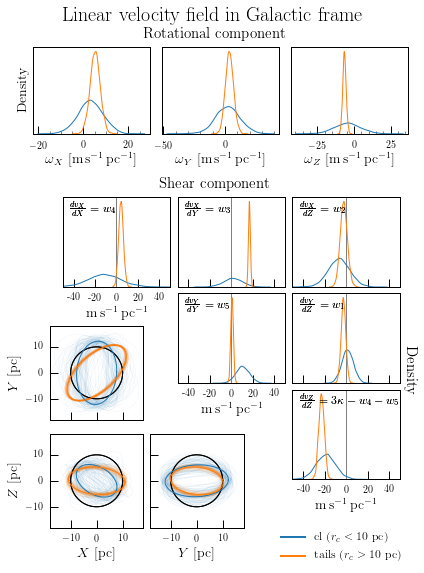

In [25]:
# Figure: posterior decomposed linear velocity field in Galactic frame
# v2 showing corner pdfs and corner deformed circles
def cleanyticks(cax):
    cax.set_yticks([])


from matplotlib.lines import Line2D


fig = plt.figure(figsize=(6, 8))
ax = fig.subplots(
    3,
    3,
    gridspec_kw=dict(
        bottom=0.16, top=0.65, left=0.15, right=0.93, wspace=0.07, hspace=0.07
    ),
    sharex=True,
    sharey=False,
)
for i, j in zip(*np.tril_indices(3, k=-1)):
    ax[i, j].set_visible(False)
for cax in ax.ravel():
    cax.axvline(0, c="0.5", lw=1)


fig.text(0.5, 0.66, "Shear component", size=15, ha="center", va="bottom")
axell = fig.subplots(
    3,
    3,
    gridspec_kw=dict(
        bottom=0.07, top=0.62, left=0.12, right=0.8, wspace=0.07, hspace=0.07
    ),
    sharex=True,
    sharey=True,
)
for i, j in zip(*np.triu_indices(3, k=0)):
    axell[i, j].set_visible(False)
axell[2, 0].set_xlabel("$X$ [pc]")
axell[2, 1].set_xlabel("$Y$ [pc]")
axell[1, 0].set_ylabel("$Y$ [pc]")
axell[2, 0].set_ylabel("$Z$ [pc]")

fig.text(0.5, 0.92, "Rotational component", size=15, ha="center", va="bottom")
axhist = fig.subplots(
    1, 3, gridspec_kw=dict(bottom=0.76, left=0.08, right=0.95, top=0.91, wspace=0.1)
)
for cax, axis in zip(axhist, ["x", "y", "z"]):
    cax.set_xlabel(
        r"$\omega_{}$ [$\mathrm{{m}}\,\mathrm{{s}}^{{-1}}\,\mathrm{{pc}}^{{-1}}$]".format(
            axis.upper()
        )
    )
    cleanyticks(cax)
axhist[0].set_ylabel("Density")

for (k, stanfit), color in zip(fit_dict.items(), ["C0", "C1", "C0", "C1"]):
    T_galactic = kn.rotate_T_to_galactic(stanfit["T_param"])
    T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) * 0.5
    Tmean = T_sym.mean(axis=0)
    print(
        k,
        np.trace(T_sym, axis1=1, axis2=2).mean(),
        np.trace(T_sym, axis1=1, axis2=2).std(),
    )

    for i, j in zip(*np.triu_indices(3, k=0)):
        axis = ["x", "y", "z"]
        ax[i, j].text(
            0.07,
            0.93,
            r"$\frac{{dv_{}}}{{d{}}}={}$".format(axis[i].upper(), axis[j].upper(), names[i,j]),
            va="top",
            ha="left",
            transform=ax[i, j].transAxes,
            size=12,
        )
        sns.kdeplot(T_sym[:, i, j], ax=ax[i, j])

    for i, j in zip(*np.tril_indices(3, k=-1)):
        plot_deformed_ellipse(np.eye(2) * 0, ax=axell[i, j], lw=1, color="k", zorder=48)
        plot_deformed_ellipse(
            Tmean[np.ix_([j, i], [j, i])] * 0.0102 * 2,
            ax=axell[i, j],
            lw=1,
            color=color,
            zorder=50,
        )
        for isample in np.random.randint(0, 4000, size=100):
            plot_deformed_ellipse(
                T_sym[isample][np.ix_([j, i], [j, i])] * 0.0102 * 2,
                ax=axell[i, j],
                lw=0.1,
                alpha=0.3,
                color=color,
                zorder=30,
            )
    for ii, par in enumerate(["omegax_gal", "omegay_gal", "omegaz_gal"]):
        vals = azfit_dict[k].posterior[par].stack(i=["chain", "draw"]).values
        axhist[ii].minorticks_on()
        axhist[ii].tick_params(axis="x", which="minor", length=3, width=0.5)
        sns.kdeplot(vals, ax=axhist[ii], color=color)

axell[2, 0].axis([-18, 18, -18, 18])
for cax in axell.ravel():
    cax.set_aspect("equal")

ax[0, 0].set_xlim(-50, 50)
for i in range(3):
    plt.setp(ax[i, i].get_xticklabels(), visible=True)
    ax[i, i].set_xticks([-40, -20, 0, 20, 40])
    ax[i, i].set_xticklabels([-40, -20, 0, 20, 40])
    ax[i, i].xaxis.set_tick_params(which="both", labelbottom=True)
    ax[i, i].set_xlabel("$\mathrm{m}\,\mathrm{s}^{-1}\,\mathrm{pc}^{-1}$")
for cax in ax.ravel():
    cleanyticks(cax)

fig.text(0.94, 0.35, "Density", rotation=-90, va="center", ha="left", size=15)

# add a custom figure legend
custom_lines = [
    Line2D([0], [0], color="C0", lw=2),
    Line2D([0], [0], color="C1", lw=2),
]
fig.legend(
    custom_lines,
    ["cl ($r_c<10~\mathrm{pc}$)", "tails ($r_c>10~\mathrm{pc}$)"],
    loc=[0.65, 0.01],
    frameon=False,
    fontsize=12,
)


fig.suptitle("Linear velocity field in Galactic frame", size=20);

savefig(fig, "decomposed_T_gal_pdfs", rasterized=True)

In [14]:
(1/(u.m/u.s/u.pc)).to(u.Myr)

<Quantity 977.79222167 Myr>

## Membership

In [26]:
df_cl = kn.reconstruct_df_from_stanfit(fit_dict['cl'])
df_tails = kn.reconstruct_df_from_stanfit(fit_dict['tails'])

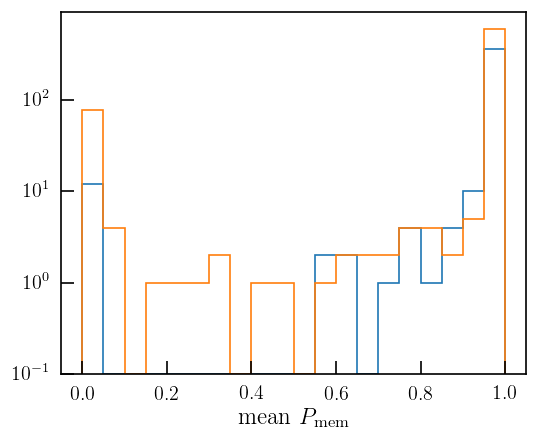

In [33]:
plt.hist(df_cl["mean_pmem"], np.linspace(0, 1, 21), log=True, histtype="step")
plt.hist(df_tails["mean_pmem"], np.linspace(0, 1, 21), log=True, histtype="step")
plt.xlabel("mean $P_\mathrm{mem}$");

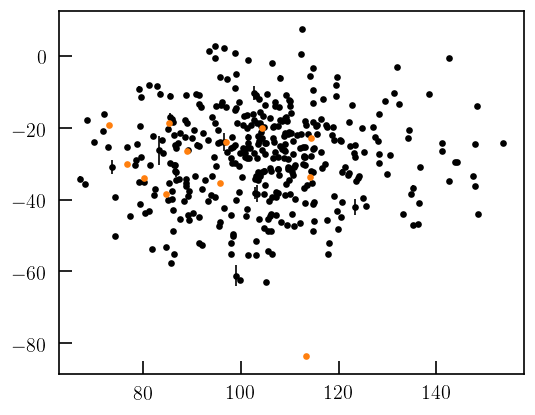

In [41]:
mem = df_cl['mean_pmem']>0.5
plt.errorbar(df_cl.loc[mem, 'pmra'], df_cl.loc[mem,'pmdec'],
             yerr=df_cl.loc[mem,'radial_velocity_error'],ls='',marker='.',c='k');
plt.errorbar(df_cl.loc[~mem, 'pmra'], df_cl.loc[~mem,'pmdec'],
             yerr=df_cl.loc[~mem,'radial_velocity_error'],ls='',marker='.',c='C1');


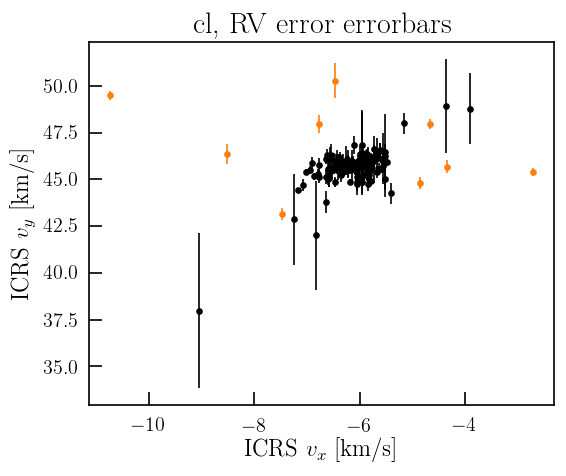

In [34]:
mem = df_cl['mean_pmem']>0.5
plt.errorbar(df_cl.loc[mem, 'vx'], df_cl.loc[mem,'vy'],
             yerr=df_cl.loc[mem,'radial_velocity_error'],ls='',marker='.',c='k');
plt.errorbar(df_cl.loc[~mem, 'vx'], df_cl.loc[~mem,'vy'],
             yerr=df_cl.loc[~mem,'radial_velocity_error'],ls='',marker='.',c='C1');
plt.title('cl, RV error errorbars')
plt.xlabel('ICRS $v_x$ [km/s]')
plt.ylabel('ICRS $v_y$ [km/s]');

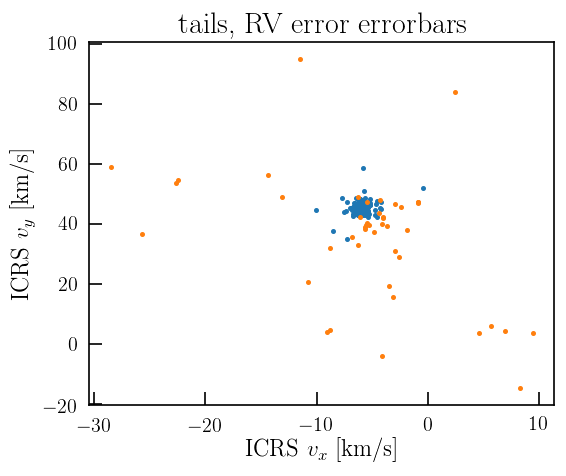

In [35]:
mem = df_tails['mean_pmem']>0.5
plt.scatter(df_tails.loc[mem, 'vx'], df_tails.loc[mem,'vy'],s=4);
plt.scatter(df_tails.loc[~mem, 'vx'], df_tails.loc[~mem,'vy'],s=4);
plt.title('tails, RV error errorbars')
plt.xlabel('ICRS $v_x$ [km/s]')
plt.ylabel('ICRS $v_y$ [km/s]');

## xyz-vxyz

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


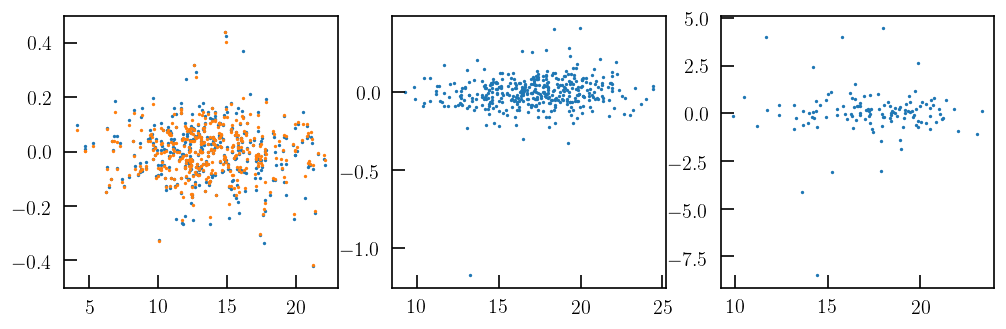

In [5]:
fit = fit_dict['cl']
rdf = kn.reconstruct_df_from_stanfit(fit)
v0 = fit['v0'].mean(axis=0)

cl = kn.Cluster(v0, 0, b0=fit.data['b0']).sample_at(rdf.g.icrs)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))

ax1.scatter(rdf.g.icrs.cartesian.z,rdf['pmra']/rdf['parallax']- cl.members.truth['pmra']/cl.members.truth['parallax'],s=1);
ax1.scatter(rdf.g.icrs.cartesian.z,(rdf['pmra']- fit['a_model'][:,:,1].mean(axis=0))/rdf['parallax'],s=1);

ax2.scatter(rdf.g.icrs.cartesian.x,rdf['pmdec']/rdf['parallax']- cl.members.truth['pmdec']/cl.members.truth['parallax'],s=1);
# ax2.scatter(rdf.g.icrs.cartesian.x,rdf['pmdec']- fit['a_model'][:,:,2].mean(axis=0),s=1);

ax3.scatter(rdf.g.icrs.cartesian.x,rdf['radial_velocity']- cl.members.truth['radial_velocity'],s=1);

ax1.set_ylim(-0.5,0.5);

(-2, 2)

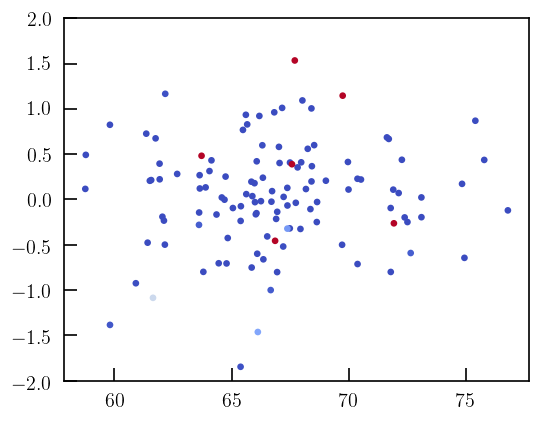

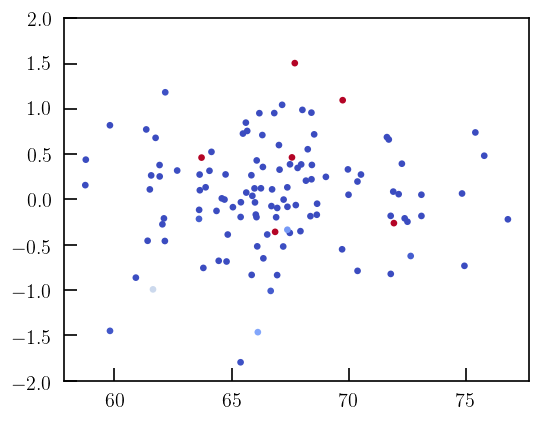

In [13]:
pmemi = fit['probmem'].mean(axis=0)
plt.scatter(rdf['ra'], rdf['radial_velocity'] - cl.members.truth['radial_velocity'], c=pmemi, cmap='coolwarm_r',s=9);
plt.ylim(-2,2)

plt.figure()
cl1 = kn.Cluster(v0, 0, b0=fit.data['b0'], T=fit['T_param'].mean(axis=0)).sample_at(rdf.g.icrs)
plt.scatter(rdf['ra'], rdf['radial_velocity'] - cl1.members.truth['radial_velocity'], c=pmemi, cmap='coolwarm_r',s=9);
plt.ylim(-2,2)


In [180]:
fit['rv_model'].shape

(4000, 127)

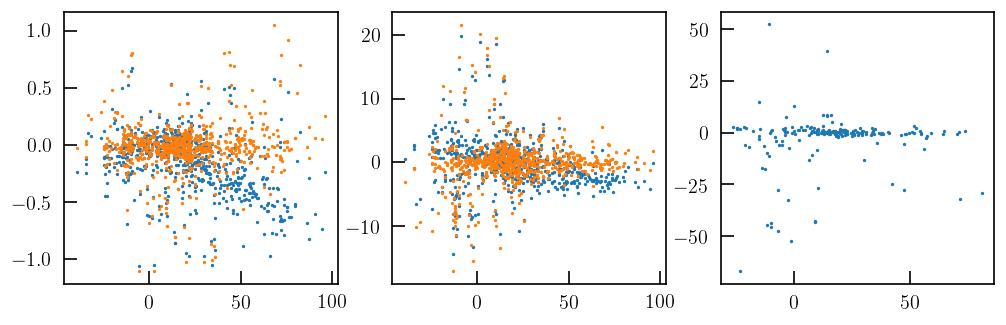

In [39]:
fit = fit_dict['tails']
rdf = kn.reconstruct_df_from_stanfit(fit)
v0 = fit.data['v0']

cl = kn.Cluster(v0, 0, b0=fit.data['b0']).sample_at(rdf.g.icrs)

fig, axarr = plt.subplots(1,3,figsize=(10,3))

ax1.scatter(rdf.g.icrs.cartesian.x, (rdf['pmra']- cl.members.truth['pmra'])/rdf['parallax'],s=1);
ax1.scatter(rdf.g.icrs.cartesian.x, (rdf['pmra']- fit['a_model'][:,:,1].mean(axis=0))/rdf['parallax'],s=1);

ax2.scatter(rdf.g.icrs.cartesian.x,rdf['pmdec']- cl.members.truth['pmdec'],s=1);
ax2.scatter(rdf.g.icrs.cartesian.x,rdf['pmdec']- fit['a_model'][:,:,2].mean(axis=0),s=1);

ax3.scatter(rdf.g.icrs.cartesian.x,rdf['radial_velocity']- cl.members.truth['radial_velocity'],s=1);
# ax3.scatter(rdf.g.icrs.cartesian.x,rdf['radial_velocity']- fit['rv_model'].mean(axis=0),s=1);

# plt.scatter(rdf.g.icrs.cartesian.x,fit['a_model'][:,:,1].mean(axis=0)- cl.members.truth['pmra'],s=1);


# plt.scatter(cl.members.truth.g.icrs.cartesian.x, cl.members.truth['pmra'],s=1)



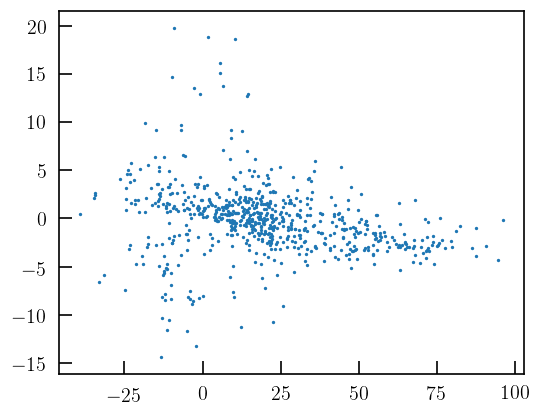

In [151]:
fit = fit_dict['tails']
rdf = kn.reconstruct_df_from_stanfit(fit)

cl = kn.Cluster(fit.data['v0'], 0, b0=fit.data['b0']).sample_at(rdf.g.icrs)
plt.scatter(rdf.g.icrs.cartesian.x,rdf['pmdec']- cl.members.truth['pmdec'],s=1);
# plt.scatter(rdf.g.icrs.cartesian.x,fit['a_model'][:,:,1].mean(axis=0)- cl.members.truth['pmra'],s=1);


# plt.scatter(cl.members.truth.g.icrs.cartesian.x, cl.members.truth['pmra'],s=1)


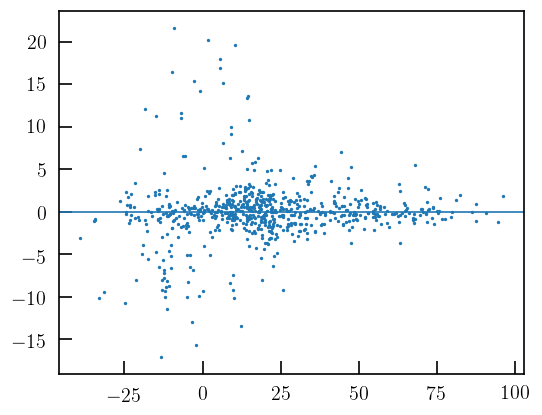

In [147]:
plt.scatter(rdf.g.icrs.cartesian.x,rdf['pmdec']- fit['a_model'][:,:,2].mean(axis=0),s=1);
plt.axhline(0);

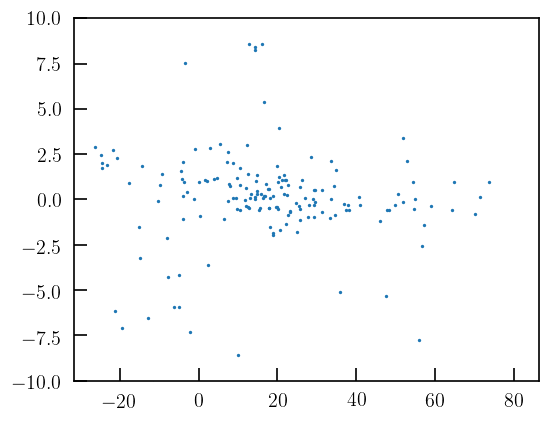

In [142]:
plt.scatter(rdf.g.icrs.cartesian.x,rdf['radial_velocity']- cl.members.truth['radial_velocity'],s=1);
plt.ylim(-10,10);

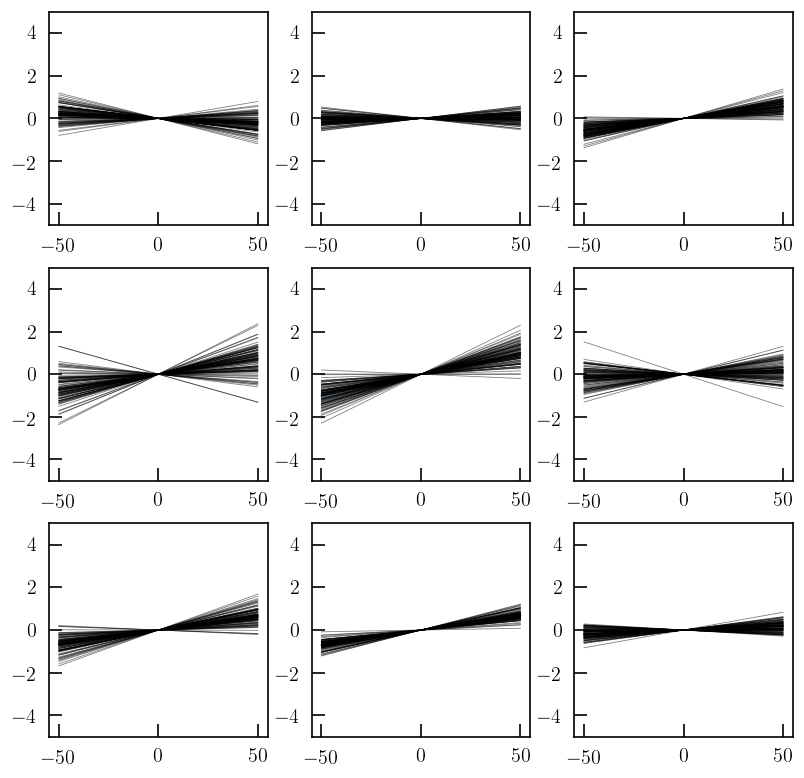

In [86]:
fit = fit_dict['tails']
rdf = kn.reconstruct_df_from_stanfit(fit)
v0_mean =[-6.086, 45.628,5.517]

fig, ax = plt.subplots(3,3, figsize=(8,8))
for i in [0,1,2]:
    for j in [0,1,2]:
        pos = ['x','y','z'][i]
        vpos=['pmra','pmdec','radial_velocity'][j]
        ax[j,i].scatter(rdf[pos]-b0[i], rdf[vpos]-v0_mean[j], c=rdf['mean_pmem'],cmap='coolwarm_r',s=4)


        m = fit['T_param'][:,j,i].mean()
        x=np.linspace(-50,50,128)
        ax[j,i].plot(x, x*m/1e3)
        idx = np.random.randint(0,4000,100)
        for mi in idx:
            m=fit['T_param'][mi,j,i]
            ax[j,i].plot(x,m*x/1e3,'k-',lw=.5,alpha=.5)
        ax[j,i].set_ylim(-5,5)
#         ax[j,i].set_xlabel(pos)
#         ax[j,i].set_ylabel('v'+vpos)

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


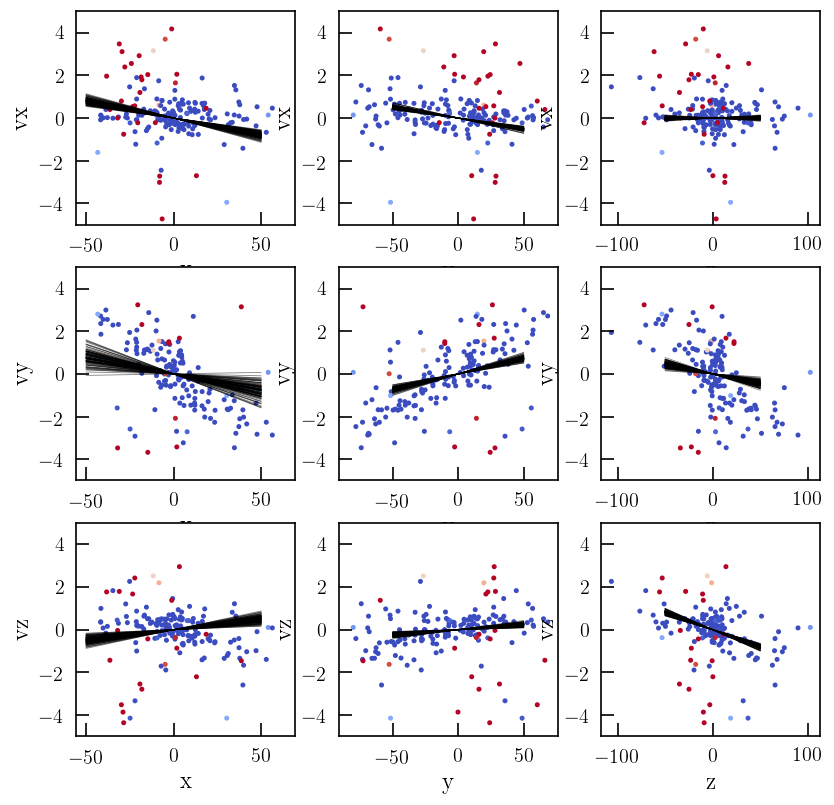

In [17]:
fit = fit_dict['tails']
rdf = kn.reconstruct_df_from_stanfit(fit)
v0_mean =[-6.086, 45.628,5.517]

fig, ax = plt.subplots(3,3, figsize=(8,8))
for i in [0,1,2]:
    for j in [0,1,2]:
        pos = ['x','y','z'][i]
        vpos=['x','y','z'][j]
        ax[j,i].scatter(rdf[pos]-b0[i], rdf['v'+vpos]-v0_mean[j], c=rdf['mean_pmem'],cmap='coolwarm_r',s=4)


        m = fit['T_param'][:,j,i].mean()
        x=np.linspace(-50,50,128)
        ax[j,i].plot(x, x*m/1e3)
        idx = np.random.randint(0,4000,100)
        for mi in idx:
            m=fit['T_param'][mi,j,i]
            ax[j,i].plot(x,m*x/1e3,'k-',lw=.5,alpha=.5)
        ax[j,i].set_ylim(-5,5)
        ax[j,i].set_xlabel(pos)
        ax[j,i].set_ylabel('v'+vpos)

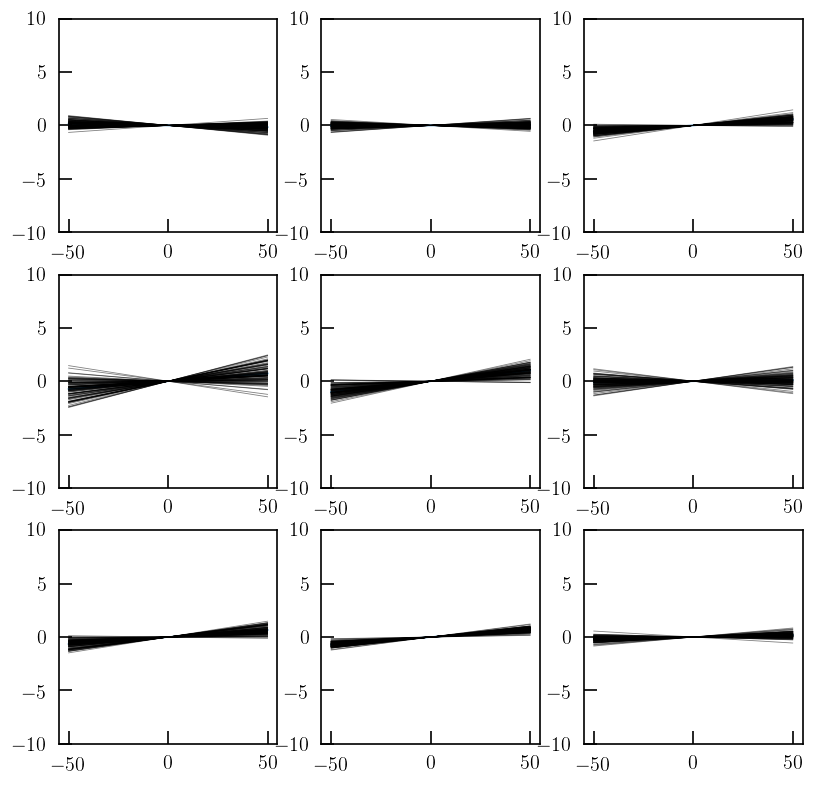

In [83]:
fit = fit_dict['tails']
rdf = kn.reconstruct_df_from_stanfit(fit)
v0_mean =[-6.086, 45.628,5.517]

fig, ax = plt.subplots(3,3, figsize=(8,8))
for i in [0,1,2]:
    for j in [0,1,2]:
        pos = ['x','y','z'][i]
        vpos=['pmra','pmdec','radial_velocity'][j]
        ax[j,i].scatter(rdf[pos]-b0[i], rdf[vpos]-v0_mean[j],
                        c=rdf['mean_pmem'],cmap='coolwarm_r',s=4)


        m = fit['T_param'][:,j,i].mean()
        x=np.linspace(-50,50,128)
        ax[j,i].plot(x, x*m/1e3)
        idx = np.random.randint(0,4000,100)
        for mi in idx:
            m=fit['T_param'][mi,j,i]
            ax[j,i].plot(x,m*x/1e3,'k-',lw=.5,alpha=.5)
        ax[j,i].set_ylim(-10,10)
#         ax[j,i].set_xlabel(pos)
#         ax[j,i].set_ylabel(vpos)

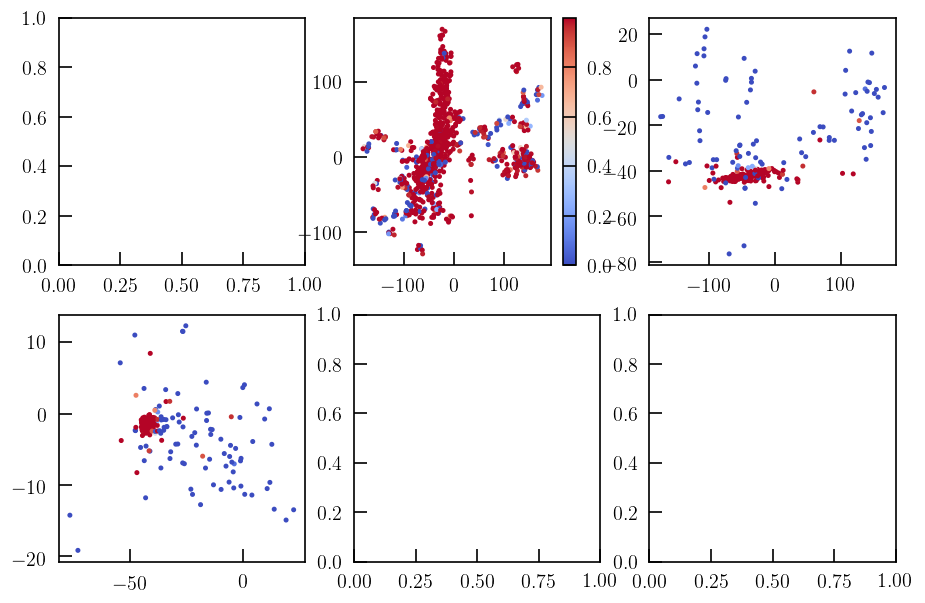

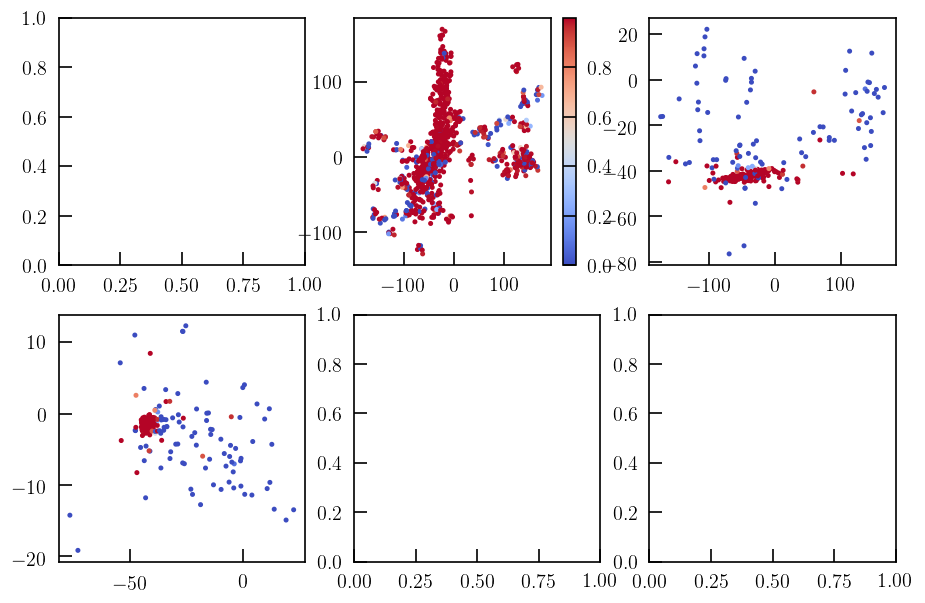

In [13]:
def plot_membership(df):
    fig,((ax1,ax2,ax3), (ax4,ax5,ax6)) =plt.subplots(2,3, figsize=(9,6))

    kwargs = dict(cmap='coolwarm', s=4)
    patches=ax2.scatter(df['gx'],df['gy'],c=df['mean_pmem'], cmap='coolwarm', s=4)
    plt.colorbar(patches,ax=ax2)

    patches=ax4.scatter(df['gvx'],df['gvz'],c=df['mean_pmem'], cmap='coolwarm', s=4)

    ax3.scatter(df['gx'],
                df['gvx'],c=df['mean_pmem'],**kwargs)
    return fig
plot_membership(df_tails)

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


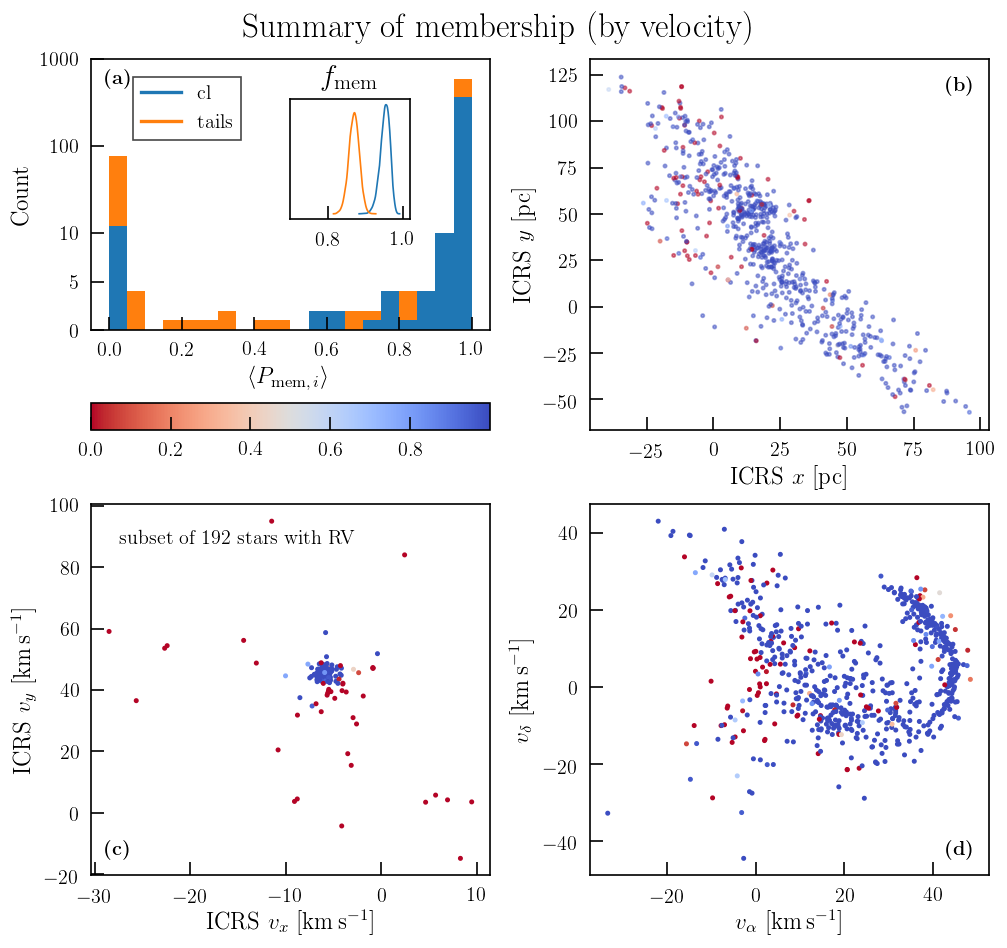

In [36]:
# Figure: summarize membership
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(
    2,
    2,
    figsize=(8.5, 8),
    gridspec_kw=dict(top=0.93, right=0.98, left=0.1, bottom=0.08, wspace=0.25),
)
fig.suptitle("Summary of membership (by velocity)", size=20)

# histogram of mean Pmem
bins = np.linspace(0, 1, 21)
_, _, patches_cl = ax[0, 0].hist(df_cl["mean_pmem"], bins=bins)
_, _, patches_tails = ax[0, 0].hist(
    df_tails["mean_pmem"], bins=bins, color="C1", zorder=-1
)
ax[0, 0].set_yscale("symlog", linthreshy=10)
ax[0, 0].set_yticks([0, 5, 10, 100, 1000])
ax[0, 0].set_yticklabels([0, 5, 10, 100, 1000])
axins = inset_axes(
    ax[0, 0],
    width=1.0,  # width = 30% of parent_bbox
    height=1.0,  # height : 1 inch
    loc=9, bbox_to_anchor=(0.55,0.8,.2,0.2),
    bbox_transform=ax[0,0].transAxes,
    borderpad=2,
)
axins.set_title("$f_\mathrm{mem}$")
for k, f in fit_dict.items():
    sns.kdeplot(f["f_mem"], ax=axins)
axins.set_xlim(0.7, 1.02)
axins.set_yticks([])
ax[0, 0].set_xlabel(r"$\langle P_{\mathrm{mem},\,i}\rangle$")
ax[0, 0].set_ylabel("Count")

(l1,) = plt.plot([], [], c="C0", lw=2)
(l2,) = plt.plot([], [], c="C1", lw=2)
ax[0, 0].legend([l1, l2], ["cl", "tails"], loc="upper left", bbox_to_anchor=(0.08,0.97),)

# ICRS x-y space
# hacking colorbar
paths = ax[0, 1].scatter(
    df_tails["x"],
    df_tails["y"],
    c=df_tails["mean_pmem"],
    s=4,
    cmap="coolwarm_r",
    visible=False,
)
_ = ax[0, 1].scatter(
    df_tails["x"],
    df_tails["y"],
    c=df_tails["mean_pmem"],
    s=4,
    cmap="coolwarm_r",
    alpha=0.5,
)
# Attach colorbar below histogram for better arrangement
ax1_divider = make_axes_locatable(ax[0, 0])
cax1 = ax1_divider.append_axes("bottom", size="10%", pad="27%")
cb = plt.colorbar(paths, cax=cax1, orientation="horizontal")

ax[0, 1].set_xlabel("ICRS $x$ [pc]")
ax[0, 1].set_ylabel("ICRS $y$ [pc]")


ax[1, 0].scatter(
    df_tails["vx"], df_tails["vy"], c=df_tails["mean_pmem"], s=4, cmap="coolwarm_r"
)
ax[1, 0].set_xlabel("ICRS $v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 0].set_ylabel("ICRS $v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 0].text(
    0.07,
    0.93,
    "subset of {} stars with RV".format(df_tails["radial_velocity"].notnull().sum()),
    transform=ax[1, 0].transAxes,
    ha="left",
    va="top",
)

ax[1, 1].scatter(
    #     out_full["parallax"],
    #     out_full["vy"],
    df_tails["pmra"] / df_tails["parallax"] * 4.74,
    df_tails["pmdec"] / df_tails["parallax"] * 4.74,
    c=df_tails["mean_pmem"],
    s=4,
    cmap="coolwarm_r",
)
# ax[1, 1].set_ylim(30, 65)
ax[1, 1].set_xlabel(r"$v_\alpha$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 1].set_ylabel(r"$v_\delta$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")

# label panels
for cax, (x, y, t) in zip(
    ax.ravel(),
    [
        (0.07, 0.93, r"\bf(a)"),
        (0.93, 0.93, r"\bf(b)"),
        (0.07, 0.07, r"\bf(c)"),
        (0.93, 0.07, r"\bf(d)"),
    ],
):
    cax.text(x, y, t, transform=cax.transAxes, va="center", ha="center")
savefig(fig, "membership", rasterized=True)

## DRV

In [111]:
drv.mean(axis=0)[52]

-0.3741769141872126

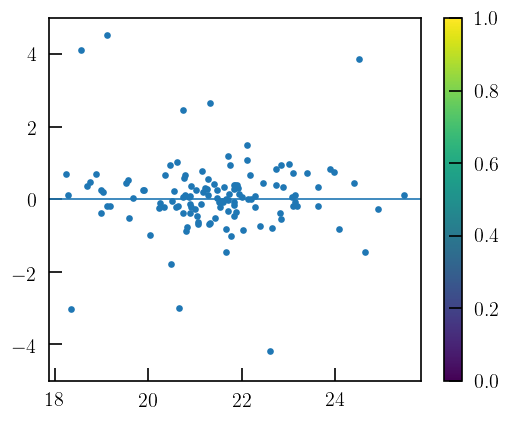

In [49]:
irv = fit_dict["dr2"].data["irv"]
drv = df["radial_velocity"].values[None, irv] - fit_dict["dr2"]["rv_model"]
patches = plt.scatter(
    df["parallax"][irv],
    drv.mean(axis=0),
#     c=df.loc[irv, "mean_pmem_dr2"],
    cmap="coolwarm",
    s=9,vmin=0,vmax=1
)
# _ = plt.scatter(
#     df["parallax"][496],
#     drv.mean(axis=0)[52],marker='s',facecolors='',edgecolors='C6'
# )
plt.errorbar(
    df["parallax"][irv], drv.mean(axis=0), #yerr=df.loc[irv, "radial_velocity_error"],
    ls="",
    c='k',zorder=-1, elinewidth=.8
)
plt.ylim(-5,5);
plt.colorbar(patches);
plt.axhline(0);

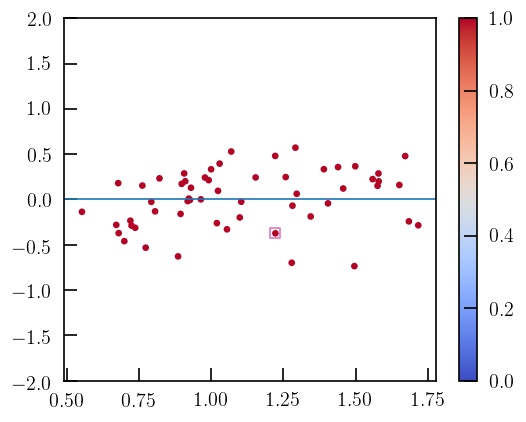

In [119]:
irv = fit_dict["harpsRV"].data["irv"]
drv = df["RV_HARPS_leao"].values[None, irv] - fit_dict["harpsRV"]["rv_model"]
patches = plt.scatter(
    df["bp_rp"][irv],
    drv.mean(axis=0),
    c=df.loc[irv, "mean_pmem_harpsRV"],
    cmap="coolwarm",
    s=9,vmin=0,vmax=1
)
_ = plt.scatter(
    df["bp_rp"][496],
    drv.mean(axis=0)[52],marker='s',facecolors='',edgecolors='C6'
)
plt.errorbar(
    df["bp_rp"][irv], drv.mean(axis=0), yerr=df.loc[irv, "eRV_HARPS_leao"], ls="",
    c='k',zorder=-1, elinewidth=.8
)
plt.ylim(-2,2);
plt.colorbar(patches);
plt.axhline(0)

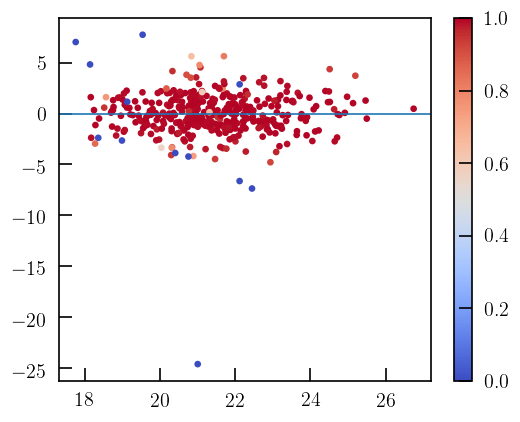

In [52]:

drv = df["pmdec"].values[None] - fit_dict["dr2"]["a_model"][:,:,2]
patches = plt.scatter(
    df["parallax"],
    drv.mean(axis=0),
    c=df["mean_pmem_dr2"],
    cmap="coolwarm",
    s=9,vmin=0,vmax=1
)
# _ = plt.scatter(
#     df["parallax"][496],
#     drv.mean(axis=0)[52],marker='s',facecolors='',edgecolors='C6'
# )
plt.errorbar(
    df["parallax"], drv.mean(axis=0), #yerr=df["pmdec_error"],
    ls="",
    c='k',zorder=-1, elinewidth=.8
)
# plt.ylim(-2,2);
plt.colorbar(patches);
plt.axhline(0)

In [106]:
np.where(irv==496)

(array([52]),)

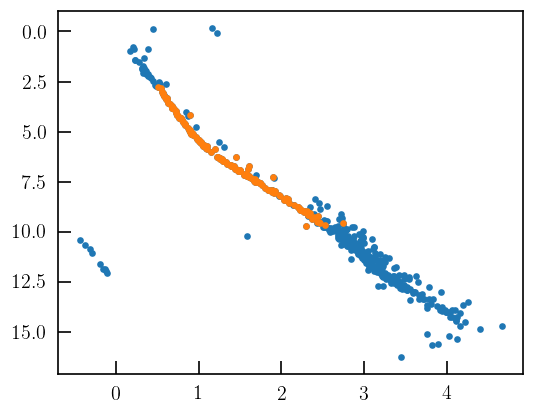

In [124]:
fig, ax = plt.subplots()
irv = fit_dict["dr2"].data["irv"]
ax.scatter(df['bp_rp'],df['phot_g_mean_mag']+df.g.distmod,s=9);
ax.scatter(df.loc[irv,'bp_rp'],df.loc[irv,'phot_g_mean_mag']+df.loc[irv].g.distmod,s=9);
# ax.scatter(df.loc[irv,'bp_rp'],df.loc[irv,'phot_g_mean_mag']+df.loc[irv].g.distmod,s=9);
ax.invert_yaxis()

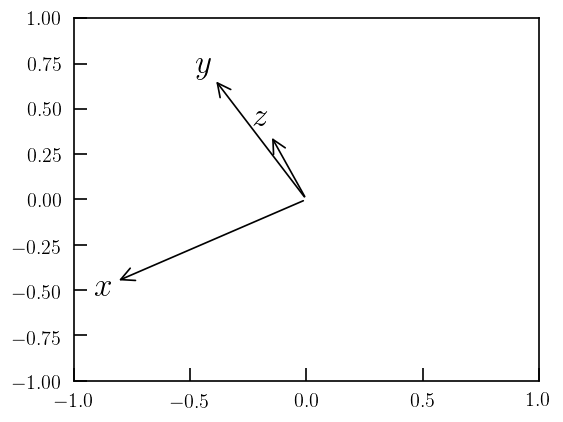

In [8]:

# annotate Galactic frame projected onto ICRS
unitv_gal_in_icrs = coord.Galactic(
    [1, 0, 0], [0, 1, 0], [0, 0, 1], representation_type="cartesian"
).transform_to(coord.ICRS).cartesian

xaxis, yaxis = 'y','z'
for i,axis in enumerate(['x','y','z']):
#     plt.plot([0,unitv_gal_in_icrs[i].x],[0,unitv_gal_in_icrs[i].y],label=axis,)
    dxdy = [getattr(unitv_gal_in_icrs[i], xaxis), getattr(unitv_gal_in_icrs[i], yaxis)]
    # using arrow and text
#     plt.arrow(*[0,0], *dxdy,
#               color='k',lw=1,)
#     plt.text(*dxdy, axis,)
    # using annotate
    ann = plt.annotate('${}$'.format(axis),
                      xy=[0,0], xycoords='data',
                      xytext=dxdy, textcoords='data',
                      size=20, va="center", ha="center",
#                       bbox=dict(boxstyle="round4", fc="w"),
                      arrowprops=dict(arrowstyle="<-"),
                      )
plt.axis([-1,1,-1,1]);

<ErrorbarContainer object of 3 artists>

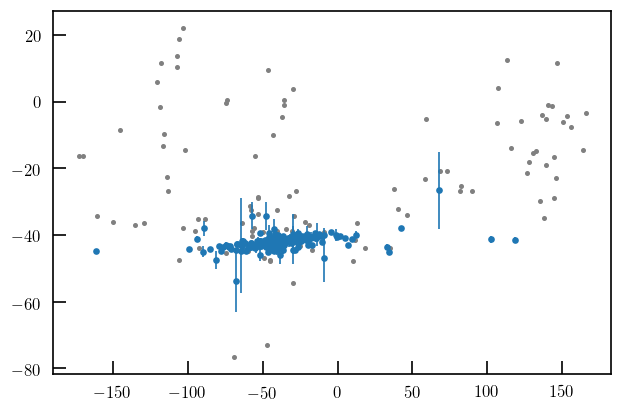

In [227]:
plt.figure(dpi=120)
plt.scatter(out_full["gx"], out_full["gvx"], s=4, c="0.5")
plt.scatter(out_full["gx"][mem], out_full["gvx"][mem], s=9)
plt.errorbar(
    out_full["gx"][mem],
    out_full["gvx"][mem],
    out_full["radial_velocity_error"][mem],
    ls="",
)

## checking RUWE

In [153]:
from wsdb import wsdb

# wsdb.upload_df(out_full[["source_id"]], "hyfull")

ruwe = wsdb.query(
    """select ruwe.source_id, ruwe
from semyeong_oh.hyfull as d left join gaia_dr2.ruwe on d.source_id=gaia_dr2.ruwe.source_id;"""
)

out_full_ruwe = out_full.merge(ruwe, on="source_id")

In [ ]:
out_full.columns

In [169]:
bad_astrometry = (out_full_ruwe['ruwe']>1.4)# | (out_full_ruwe['duplicated_source'])
print(bad_astrometry.sum())

127


In [162]:
out_full_ruwe.groupby(
    by=[out_full_ruwe["ruwe"] > 1.4, out_full_ruwe["duplicated_source"]]
)["source_id"].count()

ruwe   duplicated_source
False  False                1114
       True                  148
True   False                 117
       True                   10
Name: source_id, dtype: int64

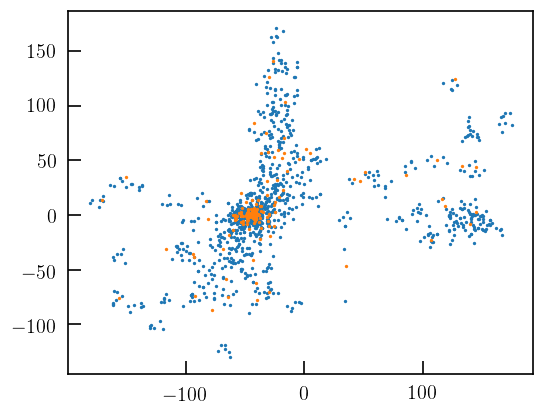

In [174]:
fig, ax = plt.subplots()
for l, g in out_full_ruwe.groupby('duplicated_source'):
    ax.scatter(g['gx'],g['gy'],s=1);

In [156]:
grp_by_pmem = out_full_ruwe.groupby(pd.cut(out_full_ruwe['mean_pmem_all'], [0., 0.5, 0.9, 1]))
grp_by_pmem[['duplicated_source']].describe()

duplicated_source                    
                          count unique    top  freq
mean_pmem_all                                      
(0.0, 0.5]                  199      2  False   183
(0.5, 0.9]                   42      2  False    40
(0.9, 1.0]                 1146      2  False  1006

In [414]:
out_full_ruwe["ruwe"].describe()

count    1389.000000
mean        1.235694
std         0.842037
min         0.725516
25%         1.008400
50%         1.089720
75%         1.203340
max        16.823600
Name: ruwe, dtype: float64

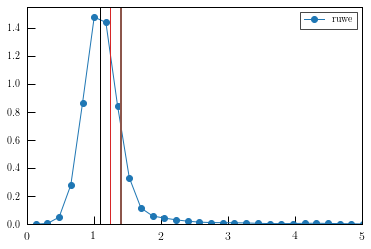

In [428]:
sns.kdeplot(out_full_ruwe["ruwe"], marker="o")
plt.xlim(0, 5)
plt.axvline(out_full_ruwe["ruwe"].median(), c="k")
plt.axvline(out_full_ruwe["ruwe"].mean(), c="C3")
plt.axvline(1.4, c="C5", lw=2);

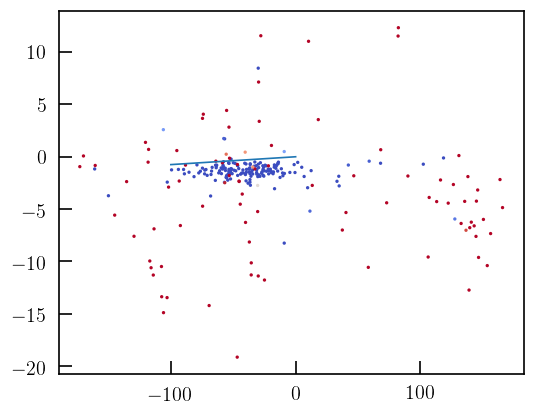

In [64]:
fig, ax = plt.subplots()
ax.scatter(df_tails['gx'], df_tails['gvz'],s=1, c=df_tails['mean_pmem'],cmap='coolwarm_r')
# ax.scatter(df_cl['gx'], df_cl['gvy'],s=1, c=df_cl['mean_pmem'],cmap='coolwarm_r')

x=np.linspace(-100,0,64)
plt.plot(x, np.mean(fit_dict['tails']['T_param'][0,1])*x*1e-3)
# plt.ylim(-30,-10)

In [4]:
supp_table = df.loc[df['Member_r19']!='other'].reset_index(drop=True).copy()
b0 = np.array([17.15474298, 41.28962638, 13.69105771])
r_c = np.linalg.norm(supp_table.g.icrs.cartesian.xyz.value - b0[:,None],axis=0)
df_cl = df.loc[r_c<400]

,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,vx,vy,vz,gx,gy,gz,gvx,gvy,gvz,ruwe
0,0,1635721458409799680,Gaia DR2 49520255665123328,49520255665123328,317315984,2015.5,64.874609,0.072621,21.753716,0.031773,...,NaN,NaN,NaN,-44.747492,4.670894,-16.251939,NaN,NaN,NaN,1.069640
1,1,1635721458409799680,Gaia DR2 49729231594420096,49729231594420096,973062374,2015.5,60.203783,0.073186,18.193881,0.038405,...,NaN,NaN,NaN,-41.196410,4.581669,-19.771640,NaN,NaN,NaN,1.028930
2,2,1635721458409799680,Gaia DR2 51383893515451392,51383893515451392,1390468914,2015.5,59.806965,0.038890,20.428049,0.021173,...,-5.668396,46.335576,5.674621,-39.683636,5.862569,-18.043019,-42.905732,-19.173408,-1.672171,1.253610
3,3,1635721458409799680,Gaia DR2 145373377272257664,145373377272257664,959042316,2015.5,66.061268,0.041402,21.736049,0.024609,...,-6.175900,45.511809,5.468302,-40.740627,3.687450,-14.122489,-42.058551,-19.211851,-1.162736,1.024000
4,4,1635721458409799680,Gaia DR2 145391484855481344,145391484855481344,1605756448,2015.5,67.003711,0.089853,21.619722,0.047903,...,NaN,NaN,NaN,-47.338002,3.704499,-15.849883,NaN,NaN,NaN,0.914597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,1384,1635721458409799680,Gaia DR2 1921730687931135360,1921730687931135360,1261333583,2015.5,357.853384,0.078994,42.070656,0.057675,...,NaN,NaN,NaN,-14.875656,38.406684,-14.525502,NaN,NaN,NaN,1.194050
1385,1385,1635721458409799680,Gaia DR2 1945436433509785088,1945436433509785088,257222751,2015.5,358.247105,0.067917,53.126442,0.051775,...,NaN,NaN,NaN,-33.864425,75.627441,-12.742858,NaN,NaN,NaN,0.997591
1386,1386,1635721458409799680,Gaia DR2 1939712960089310720,1939712960089310720,79002168,2015.5,358.379554,0.029315,48.440662,0.025782,...,NaN,NaN,NaN,-31.987230,74.931043,-19.295756,NaN,NaN,NaN,1.114040
1387,1387,1635721458409799680,Gaia DR2 1999582158500111872,1999582158500111872,107105080,2015.5,358.971475,0.058578,59.967427,0.054929,...,NaN,NaN,NaN,-36.024253,73.771202,-3.092889,NaN,NaN,NaN,0.973502
